In [1]:
!nvidia-smi

Sat Feb 12 07:57:47 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Data

In [2]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [3]:
! pip install kaggle

In [4]:
! kaggle datasets download jtiptj/chest-xray-pneumoniacovid19tuberculosis

 99% 1.73G/1.74G [00:16<00:00, 88.8MB/s]
100% 1.74G/1.74G [00:16<00:00, 114MB/s] 


In [5]:
!unzip /content/chest-xray-pneumoniacovid19tuberculosis.zip

Streaming output truncated to the last 5000 lines.
  inflating: train/NORMAL/NORMAL2-IM-0843-0001.jpeg  
  inflating: train/NORMAL/NORMAL2-IM-0845-0001.jpeg  
  inflating: train/NORMAL/NORMAL2-IM-0846-0001.jpeg  
  inflating: train/NORMAL/NORMAL2-IM-0847-0001.jpeg  
  inflating: train/NORMAL/NORMAL2-IM-0848-0001.jpeg  
  inflating: train/NORMAL/NORMAL2-IM-0849-0001.jpeg  
  inflating: train/NORMAL/NORMAL2-IM-0851-0001-0001.jpeg  
  inflating: train/NORMAL/NORMAL2-IM-0851-0001-0002.jpeg  
  inflating: train/NORMAL/NORMAL2-IM-0851-0001.jpeg  
  inflating: train/NORMAL/NORMAL2-IM-0852-0001.jpeg  
  inflating: train/NORMAL/NORMAL2-IM-0853-0001.jpeg  
  inflating: train/NORMAL/NORMAL2-IM-0854-0001.jpeg  
  inflating: train/NORMAL/NORMAL2-IM-0855-0001.jpeg  
  inflating: train/NORMAL/NORMAL2-IM-0856-0001.jpeg  
  inflating: train/NORMAL/NORMAL2-IM-0857-0001.jpeg  
  inflating: train/NORMAL/NORMAL2-IM-0858-0001.jpeg  
  inflating: train/NORMAL/NORMAL2-IM-0859-0001.jpeg  
  inflating: train/NO

## Tensorflow

In [6]:
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.python.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.python.keras.applications.mobilenet_v2 import preprocess_input
#from tensorflow.python.keras.applications import densenet
#from tensorflow.python.keras.applications.densenet import preprocess_input
from tensorflow.python.keras.applications import vgg16
from tensorflow.python.keras.applications.vgg16 import preprocess_input
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.python.keras import layers, models, Model, optimizers
from tensorflow.python.keras.layers import GlobalAveragePooling2D,Dropout
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [9]:
%cd /content/train/
%ls

/content/train
COVID19/  NORMAL/  PNEUMONIA/  TURBERCULOSIS/


In [110]:
category_names = sorted(os.listdir('/content/train'))
nb_categories = len(category_names)
img_pr_cat = []
for category in category_names:
    folder = '/content/train' + '/' + category
    img_pr_cat.append(len(os.listdir(folder)))

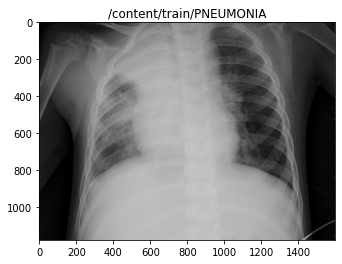

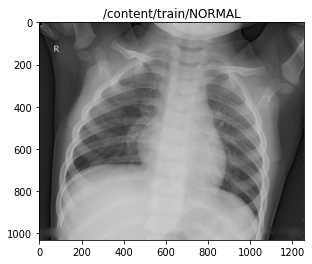

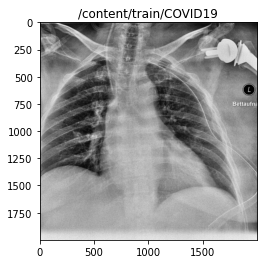

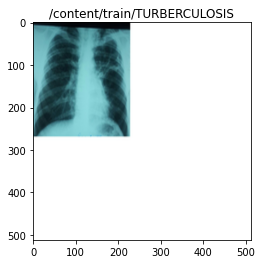

In [12]:
for subdir, dirs, files in os.walk('/content/train'):
    for file in files:
        img_file = subdir + '/' + file
        image = load_img(img_file)
        plt.figure()
        plt.title(subdir)
        plt.imshow(image)
        break

## Preprocess


In [13]:
img_height, img_width = 224,224

In [14]:
train_data_dir  = '/content/train'
val_data_dir = '/content/val'
test_data_dir = '/content/test'

In [69]:
batch_size = 64
train_datagen =  ImageDataGenerator(
    shear_range = 0.2,
    zoom_range = 0.2,
    rescale=1./255,
    rotation_range=10, 
    width_shift_range=0.2, 
    height_shift_range=0.2,
    horizontal_flip=True, 
)
test_datagen =  ImageDataGenerator(rescale=1./255)
val_datagen =  ImageDataGenerator(rescale=1./255)

print('Total number of images for "training":')
train_generator = train_datagen.flow_from_directory(
train_data_dir,
target_size = (img_height, img_width),
batch_size=batch_size,
class_mode = "categorical")

print('Total number of images for "validation":')
val_generator = test_datagen.flow_from_directory(
val_data_dir,
target_size = (img_height, img_width),
batch_size=batch_size,
class_mode = "categorical",
shuffle=False)

print('Total number of images for "testing":')
test_generator = test_datagen.flow_from_directory(
test_data_dir,
target_size = (img_height, img_width),
batch_size=batch_size,
class_mode = "categorical",
shuffle=False)

Total number of images for "training":
Found 6326 images belonging to 4 classes.
Total number of images for "validation":
Found 38 images belonging to 4 classes.
Total number of images for "testing":
Found 771 images belonging to 4 classes.



## Model



In [70]:
learning_rate = 1e-3
epochs = 20

In [71]:
img_height, img_width = 224,224
base_model=MobileNetV2(weights='imagenet',pooling='avg',include_top=False, input_shape = (img_width, img_height, 3))
#conv_base = vgg16.VGG16(weights='imagenet', include_top=False, pooling='avg', input_shape = (img_width, img_height, 3))

In [72]:
for layer in base_model.layers:
    layer.trainable=False
#Not Training existing weights of Keras Model (Transfer Learning)

In [74]:
input_shape = (img_width, img_height, 3)

In [75]:
model = models.Sequential()
model.add(base_model)
model.add(Dropout(0.2))
model.add(layers.Dense(nb_categories, activation='softmax'))

In [76]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [77]:
test_generator.class_indices

{'COVID19': 0, 'NORMAL': 1, 'PNEUMONIA': 2, 'TURBERCULOSIS': 3}

In [79]:
history =model.fit(train_generator, epochs=epochs,validation_data=val_generator)

Epoch 1/20
99/99 [==============================] - 158s 1s/step - loss: 0.4589 - accuracy: 0.8267 - val_loss: 0.6696 - val_accuracy: 0.7632
Epoch 2/20
99/99 [==============================] - 141s 1s/step - loss: 0.2551 - accuracy: 0.9044 - val_loss: 0.5920 - val_accuracy: 0.7105
Epoch 3/20
99/99 [==============================] - 139s 1s/step - loss: 0.2121 - accuracy: 0.9200 - val_loss: 0.6649 - val_accuracy: 0.7895
Epoch 4/20
99/99 [==============================] - 143s 1s/step - loss: 0.1961 - accuracy: 0.9257 - val_loss: 0.5759 - val_accuracy: 0.7895
Epoch 5/20
99/99 [==============================] - 147s 1s/step - loss: 0.1899 - accuracy: 0.9271 - val_loss: 0.5446 - val_accuracy: 0.7895
Epoch 6/20
99/99 [==============================] - 149s 2s/step - loss: 0.1828 - accuracy: 0.9325 - val_loss: 0.5355 - val_accuracy: 0.7368
Epoch 7/20
99/99 [==============================] - 146s 1s/step - loss: 0.1689 - accuracy: 0.9357 - val_loss: 0.6324 - val_accuracy: 0.7895
Epoch 8/20
99

In [80]:
model.summary()

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 1280)              2257984   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1280)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 5124      
Total params: 2,263,108
Trainable params: 5,124
Non-trainable params: 2,257,984
_________________________________________________________________


In [118]:
model.save('/content/model2-disease-classify.h5')

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


## Results

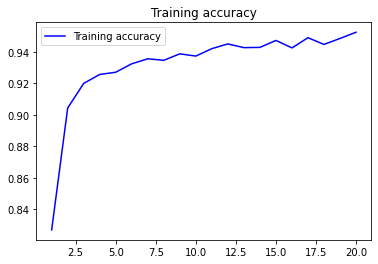

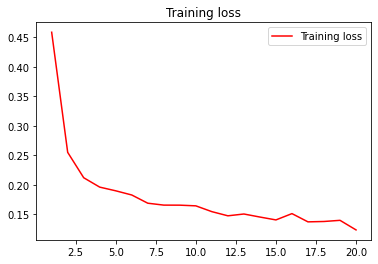

In [82]:
acc = history.history['accuracy']
loss = history.history['loss']
epochs = range(1,len(acc)+1)
plt.figure()
plt.plot(epochs, acc, 'b', label = 'Training accuracy')
plt.title('Training accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'r', label = 'Training loss')
plt.title('Training loss')
plt.legend()

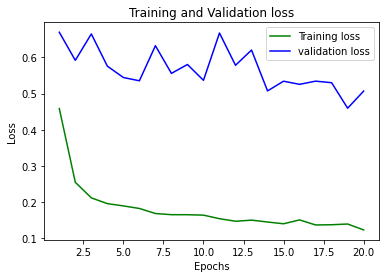

In [109]:
loss_train = history.history['loss']
loss_val = history.history['val_loss']
epochs = range(1,21)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [93]:
import itertools

In [100]:
classes = list(test_generator.class_indices.keys())
print('Classes: '+str(classes))

Classes: ['COVID19', 'NORMAL', 'PNEUMONIA', 'TURBERCULOSIS']


In [111]:
def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Greens):
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float')/cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm,decimals=2)
        cm[np.isnan(cm)] = 0.0
    thresh = cm.max()/2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2024: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Classification Report
               precision    recall  f1-score   support

      COVID19       0.94      0.97      0.95       106
       NORMAL       0.93      0.76      0.83       234
    PNEUMONIA       0.86      0.97      0.91       390
TURBERCULOSIS       1.00      0.85      0.92        41

     accuracy                           0.90       771
    macro avg       0.93      0.89      0.91       771
 weighted avg       0.90      0.90      0.90       771



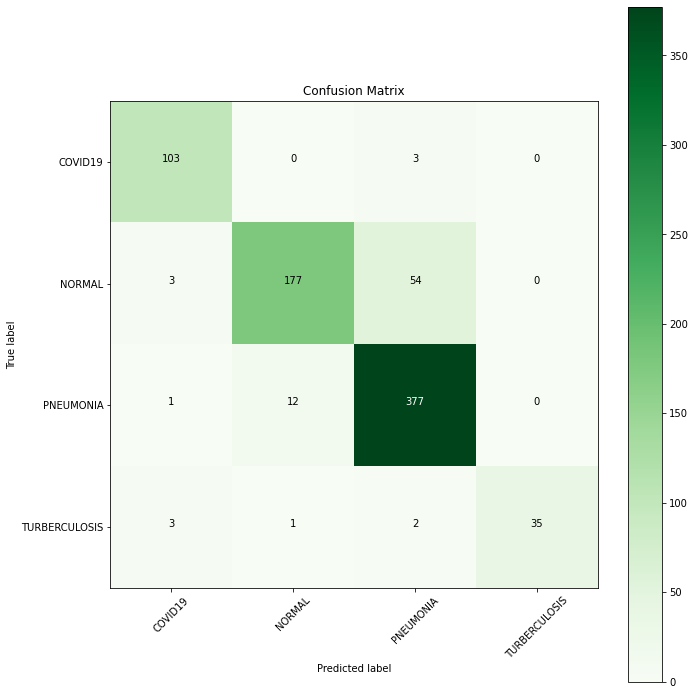

In [112]:
Y_pred = model.predict_generator(test_generator)
y_pred = np.argmax(Y_pred, axis=1)
target_names = classes
cm = confusion_matrix(test_generator.classes, y_pred)
plot_confusion_matrix(cm, target_names, normalize=False, title='Confusion Matrix')
print('Classification Report')
print(classification_report(test_generator.classes, y_pred, target_names=target_names))

In [113]:
np.mean(history.history['accuracy'])

0.9320581734180451

In [114]:
score = model.evaluate_generator(train_generator,steps=3)
print('Train loss:',score[0])
print('Train accuracy:',score[1])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1996: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


Train loss: 0.10925132036209106
Train accuracy: 0.96875


In [115]:
score = model.evaluate_generator(test_generator,steps=3)
print('Test loss:',score[0])
print('Test accuracy:',score[1])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1996: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


Test loss: 0.1725369244813919
Test accuracy: 0.9322916865348816
